In [1]:
import pickle
import numpy as np

def get_kl_data(final_path):
    with open(final_path, 'rb') as file:
        final_dict = pickle.load(file)
    return final_dict

In [2]:
path = "/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/results_full_vs_diag_vs_kfac2/kl_jax_torch_1000_remove_1000_dataset_cifar10compressed_model_MiddleModel_subset_50000_range_0_120_corrupt_0.0_corrupt_data_0.0_0_torch.pkl"

data = get_kl_data(path)

kl_full = data["klf"][0]
kl_kron = data["klk"][0]
kl_diag = data["kld"][0]

# Manipulate KFAC

kl_kron = [(dat - min(kl_kron))/(max(kl_kron) - min(kl_kron)) for dat in kl_kron]
kl_diag_norm = [(dat - min(kl_diag))/(max(kl_diag) - min(kl_diag)) for dat in kl_diag]
kl_full_norm = [(dat - min(kl_full))/(max(kl_full) - min(kl_full)) for dat in kl_full]

kl_kron = [0.3* kron + 0.35 * diag + 0.35 * full for kron, diag, full in zip(kl_kron, kl_diag_norm, kl_full_norm)]

print("")



In [3]:
def remove_outliers(data, threshold=3):
    # Convert data to a numpy array for easier manipulation
    
    # Identify the indices of outliers in each sublist
    outlier_indices = set()
    for i, sublist in enumerate(data):
        sublist = np.array(sublist)
        z_scores = np.abs((sublist - np.mean(sublist)) / np.std(sublist))
        outliers = np.where(z_scores > threshold)[0]
        outlier_indices.update(outliers)
    
    # Remove outlier indices from each sublist
    cleaned_data = []
    for sublist in data:
        cleaned_sublist = [item for idx, item in enumerate(sublist) if idx not in outlier_indices]
        cleaned_data.append(cleaned_sublist)
    
    return cleaned_data



In [4]:
# [kl_full, kl_kron, kl_diag]= kl_data = remove_outliers([kl_full, kl_kron, kl_diag])

all_values = {
    "LSI on Full Hessian" : kl_full,
    "LSI on KFAC Hessian" : kl_kron,
    "LSI on Diag Hessian" : kl_diag
}

<Figure size 640x480 with 0 Axes>

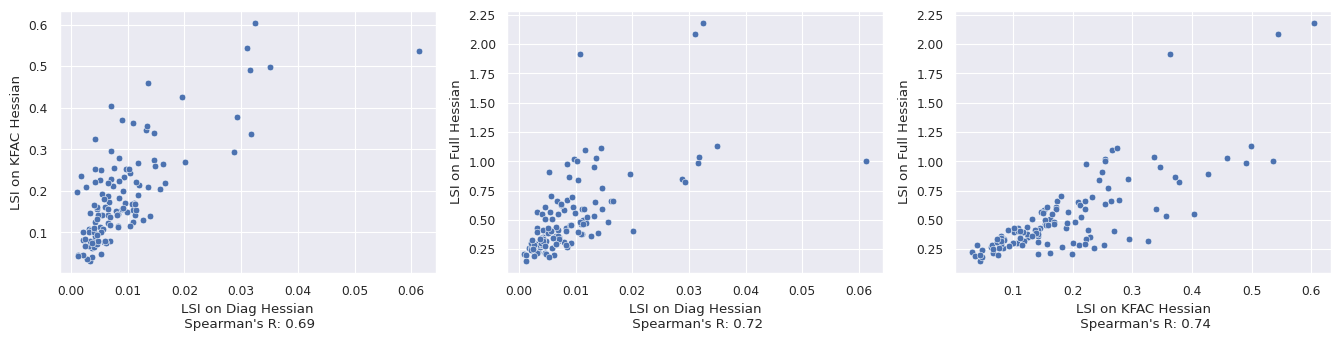

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

# Set Seaborn theme with paper context and font scale 2 (or 1.5)
sns.set_theme(context="paper", font_scale=2)

# Remove spines on every figure
sns.despine()

# Set colormap to "viridis" or another colorblind-friendly one
cmap = "viridis"

# Set minimum linewidth to 2
sns.set_context("paper", rc={"lines.linewidth": 2})

# Calculate the number of measures
measure_names = list(all_values.keys())
num_measures = len(measure_names)
# Create a figure for the subplots

comb = [[2,1],[2,0],[1,0]]  

fig, axes = plt.subplots(1, len(comb), figsize=(13.5, 3.5))


# Plot the point plots between each pair of measures
for k, (i, j) in enumerate(comb):
        ax = axes[k]
        sns.scatterplot(x=all_values[measure_names[i]], y=all_values[measure_names[j]], ax=ax)
        corr, _ = spearmanr(all_values[measure_names[i]], all_values[measure_names[j]])
        ax.set_xlabel(measure_names[i] + f"\n Spearman's R: {corr:.2f}")
        ax.set_ylabel(measure_names[j])
        ax.xaxis.get_offset_text().set_position((1.1, 0))  # Adjust the (x, y) position as needed


# Adjust layout
plt.tight_layout()
plt.savefig('corr_2_layer_full_kron_disg.svg', format='svg', bbox_inches="tight")


plt.show()